In [34]:
import sys, os
import theano
from collections import OrderedDict
from copy import deepcopy
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams
import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions import Interpolated
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')
from tqdm import tqdm
from collections import Counter
import scanpy as sc
import pandas as pd
sc.settings.autosave=False
sc.settings.autoshow=True

maxgenes=10000
n_iterations=1000
#adatapath=os.path.expanduser('/scrapp2/mtschmitz/5k_pbmc_v3')
#genomename="refdata-celranger-mmul8-toplevel"
#genomename=''
#samplename='5kPBMC'


adatapaths=['/home/mt/Downloads/1k_hgmm','/scrapp2/mtschmitz/5k_pbmc_v3','/scrapp2/mtschmitz/E40_motor_Out','E50_motor_Out','E65_motor_Out','E80motor_Out','E100motor_Out']
genomenames=['','',"refdata-celranger-mmul8-toplevel","refdata-celranger-mmul8-toplevel","refdata-celranger-mmul8-toplevel",
            "refdata-celranger-mmul8-toplevel","refdata-celranger-mmul8-toplevel"]
samplenames=['1kHGMM','5kPCMB','E40','E50','E65','E80','E100']
adatapath=adatapaths[0]
#genomename="refdata-celranger-mmul8-toplevel"
genomename=''
samplename=samplenames[0]


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.var` of view, making a copy.


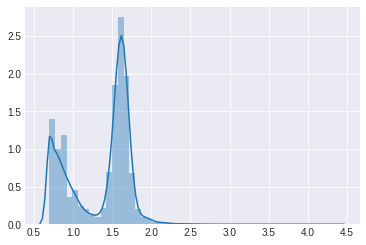

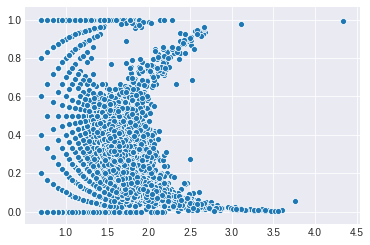

In [35]:
adata = sc.read_10x_mtx(os.path.join(adatapath,'outs/raw_feature_bc_matrix',genomename),cache=True)
bcs=list(pd.read_csv(os.path.join(adatapath,'outs/filtered_feature_bc_matrix',genomename,'barcodes.tsv.gz')).iloc[:,0])
#adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-celranger-Pabe2-toplevel')
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=50,inplace=True)
sc.pp.filter_cells(adata,min_counts=5,inplace=True)
#adata=adata[adata.obs.n_counts.argsort(),:]
adata.var['Mouse'] = ['mm10' in x for x in adata.var.index]

cell_inds=np.where([x in bcs for x in adata.obs.index])[0]
junk_inds=np.where([x not in bcs for x in adata.obs.index])[0]
adata.obs['PercentM'] =adata[:,list(adata.var['Mouse'])].X.sum(1)/adata.X.sum(1)

ambient_counts=np.log10(adata[[x not in bcs for x in adata.obs.index] ,:].X.sum(1).A1)
sns.distplot(ambient_counts)
plt.show()
sns.scatterplot(ambient_counts,np.array(adata[[x not in bcs for x in adata.obs.index],:].obs['PercentM']))
plt.show()
#adata=adata[:,(-adata[junk_inds,:].X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])]]
betaAmbient = adata[junk_inds,:].X.sum(axis=0)/adata[junk_inds,:].X.sum(axis=1).sum()
betaAmbientDict=dict(zip(list(adata.var.index), betaAmbient.A1))




sc.settings.figdir=os.path.expanduser('~/figs/'+samplename)
if not os.path.exists(sc.settings.figdir):
        os.makedirs(sc.settings.figdir)

#adata._inplace_subset_obs(np.random.choice(adata.obs.index,10000,replace=False))
#adata._inplace_subset_var(np.random.choice(adata.var.index,4000,replace=False))
#sc.pp.filter_genes(adata, min_cells=50,inplace=True)
#sc.pp.filter_cells(adata,min_counts=5,inplace=True)

[[1.         0.70313739]
 [0.70313739 1.        ]]
[[1.         0.71153975]
 [0.71153975 1.        ]]


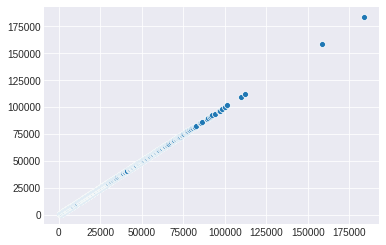

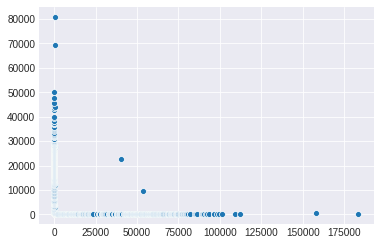

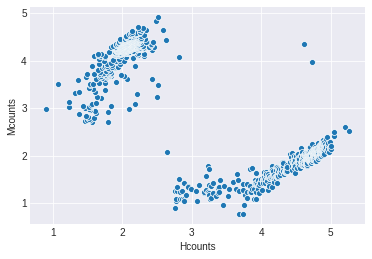

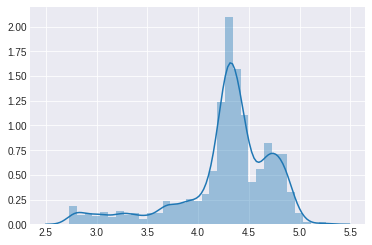

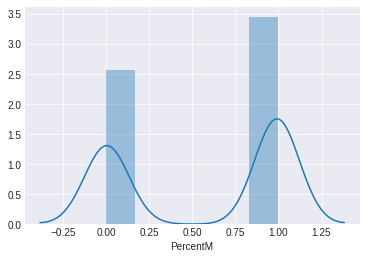

In [36]:
freshadata=sc.read_h5ad('/home/mt/Downloads/1k_hgmm/outs/ambientsubtracted.h5ad')
adata._inplace_subset_obs(freshadata.obs.index)
adata._inplace_subset_var(freshadata.var.index)
print(np.corrcoef((adata.X-freshadata.X).sum(0),freshadata.var['lda_9']))
print(np.corrcoef((adata.X-freshadata.X).sum(0),[betaAmbientDict[i] for i in freshadata.var.index]))

sns.scatterplot(freshadata.X.sum(1).A1,adata.X.sum(1).A1)
plt.show()

adata.obs['PercentM'] =adata[:,list(adata.var['Mouse'])].X.sum(1)/adata.X.sum(1)
adata.obs['Mcounts'] =adata[:,list(adata.var['Mouse'])].X.sum(1)
adata.obs['Hcounts'] =adata[:,list(np.invert(adata.var['Mouse']))].X.sum(1)

sns.scatterplot(np.array(adata.obs['Hcounts']),np.array(adata.obs['Mcounts']))
plt.show()
sns.scatterplot(np.log10(adata.obs['Hcounts']+1),np.log10(adata.obs['Mcounts']+1))
plt.show()
sns.distplot(np.log10(adata.X.sum(1)))
plt.show()
sns.distplot(adata.obs['PercentM'])
plt.show()


In [37]:
(freshadata.X*np.array([betaAmbientDict[i] for i in freshadata.var.index]))

array([3.7487787e-01, 6.8217492e-01, 2.7665740e-01, ..., 1.9522462e+02,
       2.3630229e+02, 3.1545023e+02], dtype=float32)

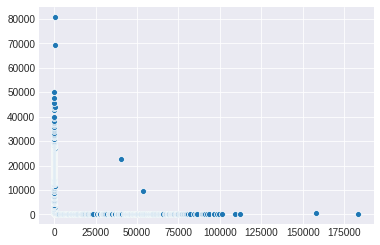

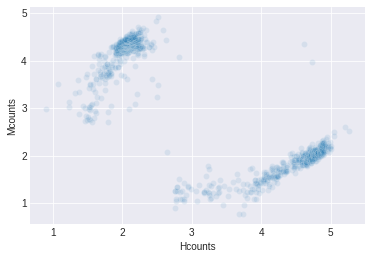

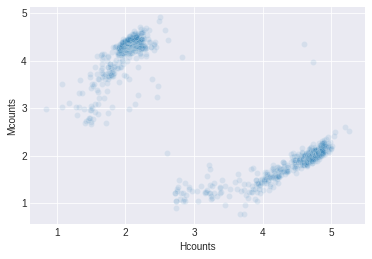

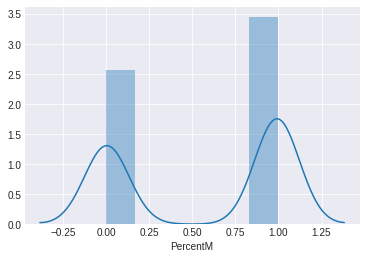

In [38]:
freshadata.var['Mouse'] = ['mm10' in x for x in freshadata.var.index]
freshadata.obs['PercentM'] =freshadata[:,list(freshadata.var['Mouse'])].X.sum(1)/freshadata.X.sum(1)
freshadata.obs['Mcounts'] =freshadata[:,list(freshadata.var['Mouse'])].X.sum(1)
freshadata.obs['Hcounts'] =freshadata[:,list(np.invert(freshadata.var['Mouse']))].X.sum(1)
freshadata.obs['BambMult']=(freshadata.X*np.array([betaAmbientDict[i] for i in freshadata.var.index]))
sns.scatterplot(np.array(freshadata.obs['Hcounts']),np.array(freshadata.obs['Mcounts']))
plt.show()
sns.scatterplot(np.log10(adata.obs['Hcounts']+1),np.log10(adata.obs['Mcounts']+1),alpha=.1)
plt.show()
sns.scatterplot(np.log10(freshadata.obs['Hcounts']+1),np.log10(freshadata.obs['Mcounts']+1),alpha=.1)
plt.show()
sns.distplot(freshadata.obs['PercentM'])
plt.show()


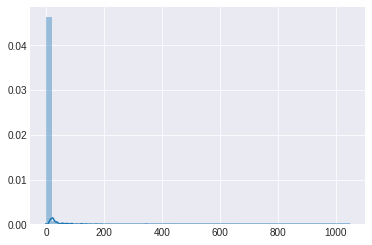

[[1.         0.73949262]
 [0.73949262 1.        ]]
[[1.         0.26127859]
 [0.26127859 1.        ]]


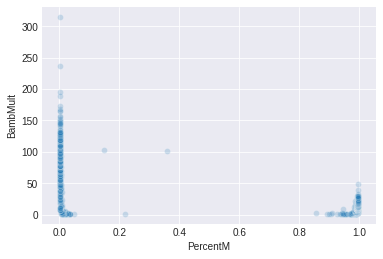

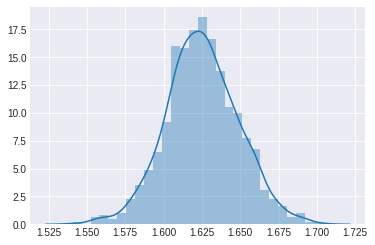

In [39]:
humanmousegenes=adata[adata.obs['PercentM']<.2,][:,adata.var['Mouse']]
sns.distplot(freshadata[freshadata.obs['PercentM']<.2,][:,freshadata.var['Mouse']].X.sum(0))
plt.show()
print(np.corrcoef( humanmousegenes.X.sum(0) ,[betaAmbientDict[i] for i in humanmousegenes.var.index]))
mousehumangenes=adata[adata.obs['PercentM']>.8,][:,np.invert(adata.var['Mouse'])]
print(np.corrcoef( mousehumangenes.X.sum(0) ,[betaAmbientDict[i] for i in mousehumangenes.var.index]))
sns.scatterplot(freshadata.obs['PercentM'],freshadata.obs['BambMult'],alpha=.2)
plt.show()
(adata.X-freshadata.X).sum(0).sum()
sns.distplot(np.log10(freshadata.obs['lda_9']*freshadata.obs['n_counts']))

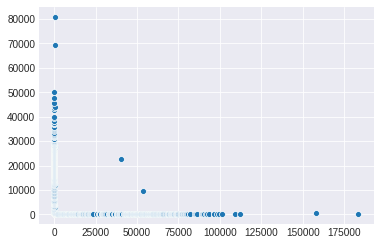

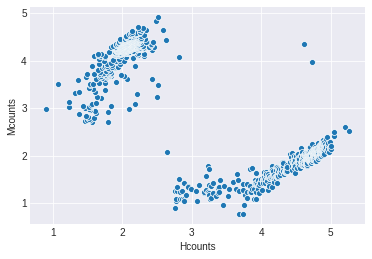

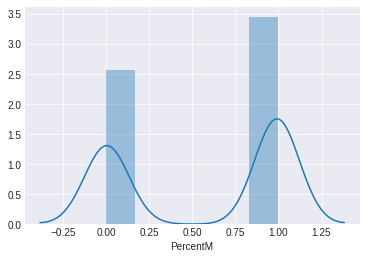

In [40]:
sns.scatterplot(np.array(adata.obs['Hcounts']),np.array(adata.obs['Mcounts']))
plt.show()
sns.scatterplot(np.log10(adata.obs['Hcounts']+1),np.log10(adata.obs['Mcounts']+1))
plt.show()
sns.distplot(adata.obs['PercentM'])
plt.show()


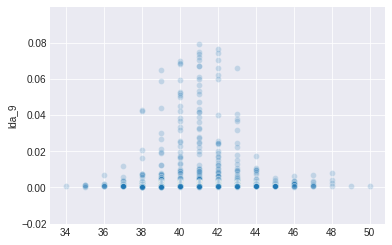

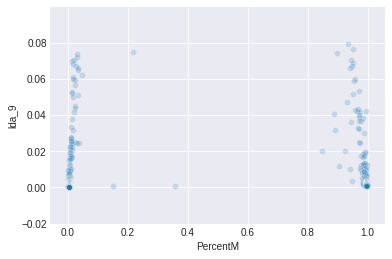

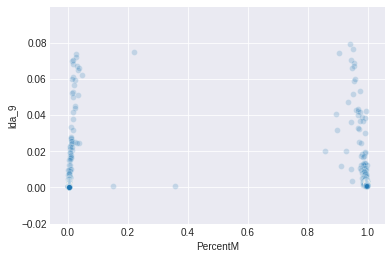

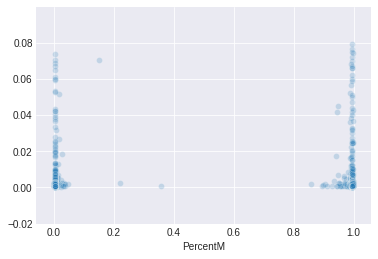

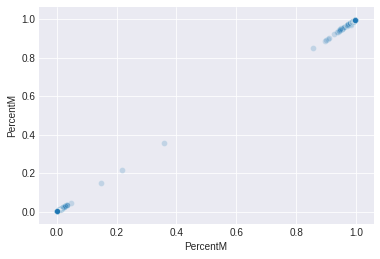

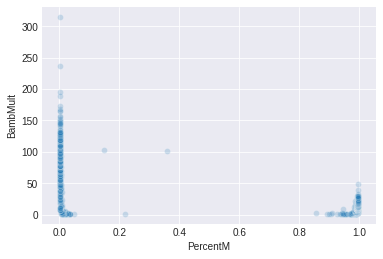

In [41]:
sns.scatterplot((adata.X-freshadata.X).sum(1).A1,freshadata.obs['lda_9'],alpha=.2)
plt.show()
sns.scatterplot(adata.obs['PercentM'],freshadata.obs['lda_9'],alpha=.2)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],freshadata.obs['lda_9'],alpha=.2)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],np.random.permutation(list(freshadata.obs['lda_9'])),alpha=.2)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],adata.obs['PercentM'],alpha=.2)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],freshadata.obs['BambMult'],alpha=.2)
plt.show()



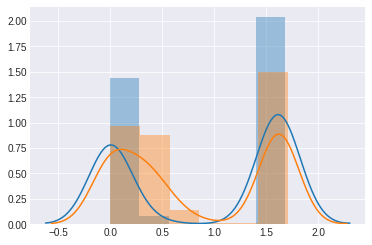

In [42]:
sns.distplot(np.log10((adata[:,adata.var['Mouse']].X-freshadata[:,adata.var['Mouse']].X).sum(1)+1))
sns.distplot(np.log10((adata[:,np.invert(adata.var['Mouse'])].X-freshadata[:,np.invert(adata.var['Mouse'])].X).sum(1)+1))


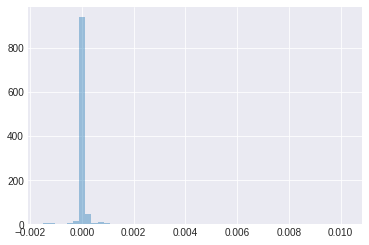

In [43]:
sns.distplot(freshadata[:,list(freshadata.var['Mouse'])].X.sum(1)/freshadata.X.sum(1)-adata[:,list(adata.var['Mouse'])].X.sum(1)/adata.X.sum(1),kde=False)


... storing 'feature_types' as categorical


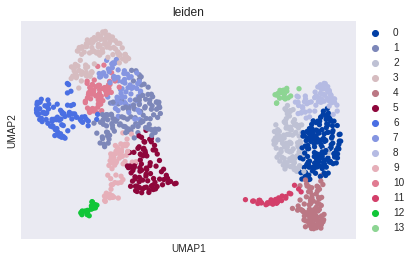

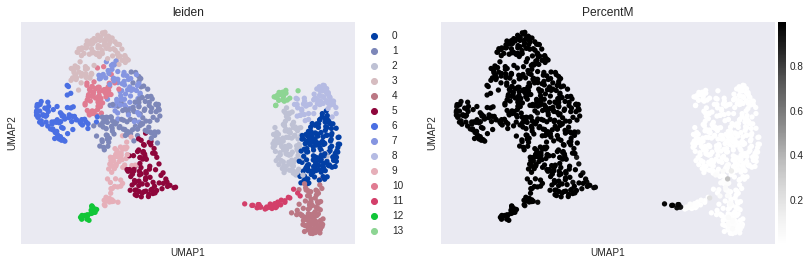

In [44]:
sc.pp.filter_genes(adata,min_counts=2,inplace=True)
sc.pp.filter_cells(adata,min_counts=100,inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=5000,inplace=True)
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])
sc.pl.umap(adata, color=['leiden','PercentM'])


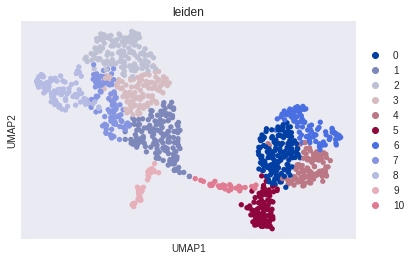

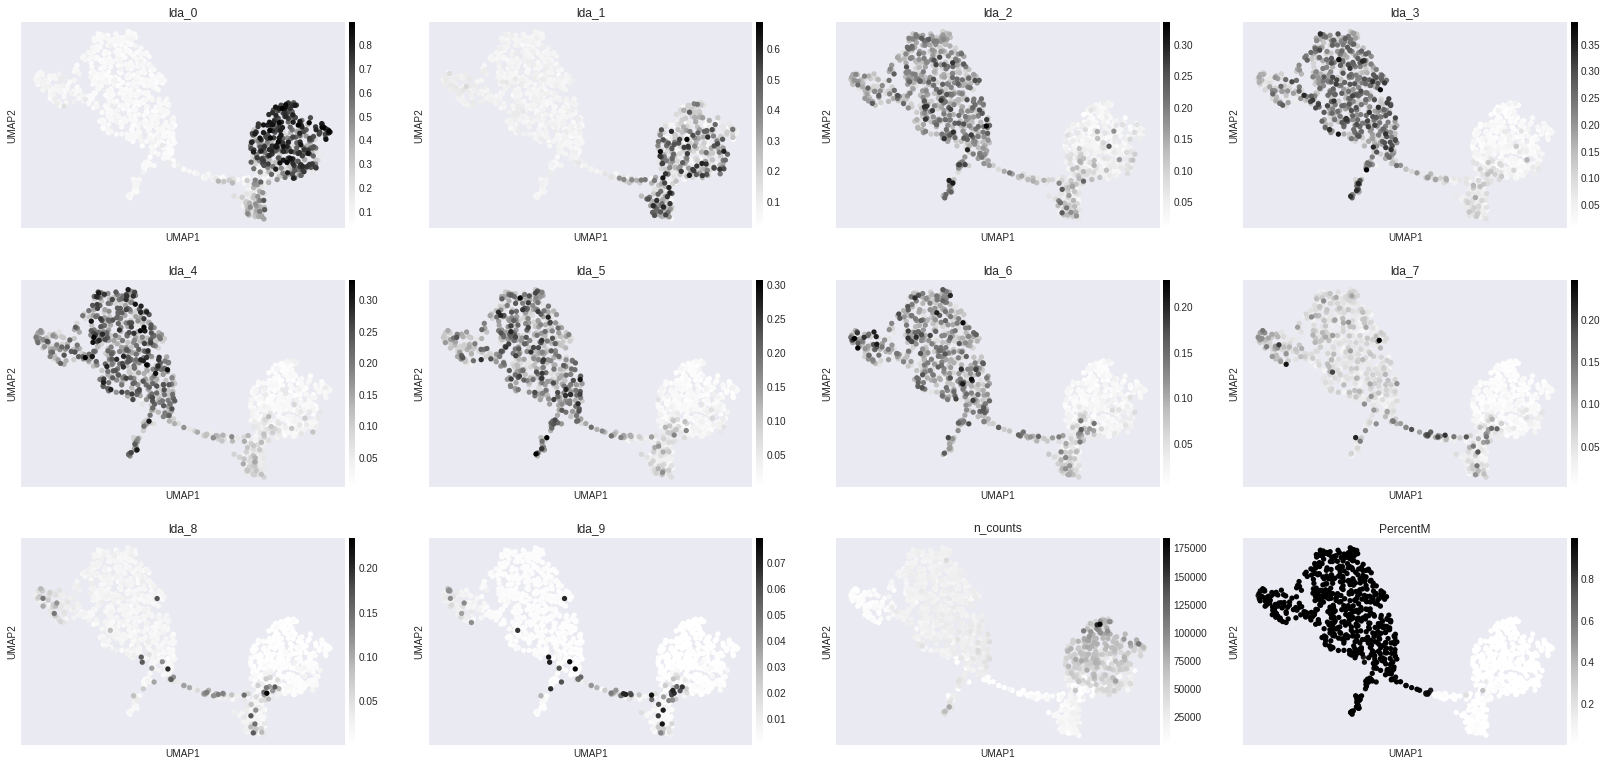

In [45]:
sc.pp.filter_genes(freshadata,min_counts=2,inplace=True)
sc.pp.filter_cells(freshadata,min_counts=100,inplace=True)
sc.pp.normalize_total(freshadata, target_sum=1e4)
sc.pp.log1p(freshadata)
sc.pp.highly_variable_genes(freshadata,n_top_genes=5000,inplace=True)
sc.pp.scale(freshadata, max_value=10)
sc.pp.pca(freshadata)
sc.pp.neighbors(freshadata)
sc.tl.umap(freshadata)
sc.tl.leiden(freshadata)
sc.pl.umap(freshadata, color=['leiden'])


sc.pl.umap(freshadata, color=['lda_0','lda_1','lda_2','lda_3','lda_4','lda_5','lda_6','lda_7','lda_8','lda_9','n_counts','PercentM'])


# In[ ]:

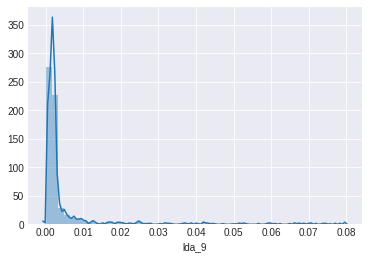

In [46]:
sns.distplot(freshadata.obs['lda_9'])

In [47]:
pbmcs = sc.read_10x_mtx(os.path.join('/home/mt/Downloads/PBMC_MMHG_Out/outs/filtered_feature_bc_matrix/'),cache=True)


Trying to set attribute `.var` of view, making a copy.


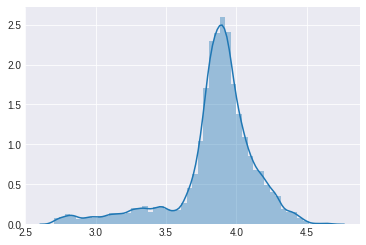

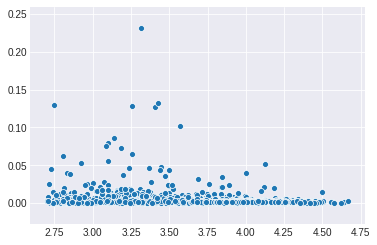

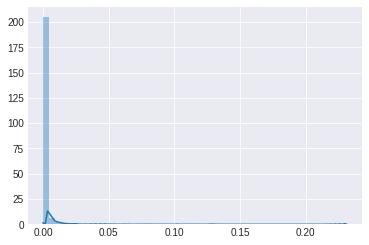

In [48]:
sc.pp.filter_genes(pbmcs, min_cells=50,inplace=True)
sc.pp.filter_cells(pbmcs,min_counts=500,inplace=True)
#adata=adata[adata.obs.n_counts.argsort(),:]
pbmcs.var['Mouse'] = ['mm10' in x for x in pbmcs.var.index]

pbmcs.obs['PercentM'] =pbmcs[:,list(pbmcs.var['Mouse'])].X.sum(1)/pbmcs.X.sum(1)

ambient_counts=np.log10(pbmcs[[x not in bcs for x in pbmcs.obs.index] ,:].X.sum(1).A1)
sns.distplot(ambient_counts)
plt.show()
sns.scatterplot(np.log10(pbmcs.X.sum(1).A1),np.array(pbmcs.obs['PercentM']))
plt.show()
sns.distplot(np.array(pbmcs.obs['PercentM']))
plt.show()


In [49]:
pbmcs.obs['PercentM']
pbmcs[:,pbmcs.var['Mouse']].X.sum()/pbmcs[:,np.invert(pbmcs.var['Mouse'])].X.sum()

0.001656911